# Pseudotime

In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.colors import ListedColormap
from anndata import AnnData, concat

# Customized packages
import starmap.sc_util as su

# test()

In [2]:
# Get functions 

import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

## IO

In [3]:
# Set path
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')

out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

## Input

In [4]:
# Load new data
adata = sc.read_h5ad(os.path.join(out_path, '2022-03-01-Hu-AD-stardist-scaled.h5ad'))

# combine time and group label
adata.obs['time-group'] = adata.obs['time'].astype(str) + '-' + adata.obs['group'].astype(str)
adata.obs['time-group'] = adata.obs['time-group'].astype('category')
adata.obs['time-group'] = adata.obs['time-group'].cat.reorder_categories(['8months-disease', '8months-control', '13months-disease', '13months-control'])

adata

AnnData object with n_obs × n_vars = 72165 × 2766
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'tau', 'group', 'time', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'seg_label', 'region', 'time-group'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'detected', 'highly_variable', 'n_cells', 'mean', 'std'
    uns: 'ADmouse_11346_morph', 'ADmouse_11351_morph', 'ADmouse_9494_morph', 'ADmouse_9498_morph', 'ADmouse_9707_morph', 'ADmouse_9723_2_morph', 'ADmouse_9723_morph', 'ADmouse_9735_morph', 'cell_type_hex_dict', 'cell_type_order', 'cell_type_rgb_dict', 'top_level_hex_dict', 'top_level_order', 'top_level_rgb_dict'
    layers: 'corrected', 'norm', 'raw', 'scaled'

## Cell-type

### single type

In [83]:
# Embedding parameters
emb_dict = {
    'Micro': {'n_neighbors': 30, 'n_pcs': 3, 'min_dist': .1, 'cluster_resolution': .1},
    'Astro': {'n_neighbors': 30, 'n_pcs': 4, 'min_dist': .1, 'cluster_resolution': .4},
    'Endo': {'n_neighbors': 20, 'n_pcs': 5, 'min_dist': .1, 'cluster_resolution': .1},
    'CTX-Ex': {'n_neighbors': 30, 'n_pcs': 6, 'min_dist': .1, 'cluster_resolution': .3},
    'Inh': {'n_neighbors': 20, 'n_pcs': 16, 'min_dist': 1, 'cluster_resolution': .5},
           }

save_embedding = False

In [152]:
# Subset
sub_id = 'Astro'
curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 6789 × 2766
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'tau', 'group', 'time', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'seg_label', 'region', 'time-group'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'detected', 'highly_variable', 'n_cells', 'mean', 'std'
    uns: 'ADmouse_11346_morph', 'ADmouse_11351_morph', 'ADmouse_9494_morph', 'ADmouse_9498_morph', 'ADmouse_9707_morph', 'ADmouse_9723_2_morph', 'ADmouse_9723_morph', 'ADmouse_9735_morph', 'cell_type_hex_dict', 'cell_type_order', 'cell_type_rgb_dict', 'top_level_hex_dict', 'top_level_order', 'top_level_rgb_dict', 'iroot'
    layers: 'corrected', 'norm', 'raw', 'scaled'

In [153]:
sub_level_fig_path = os.path.join(fig_path, sub_id)
if not os.path.exists(sub_level_fig_path):
    os.mkdir(sub_level_fig_path)

In [157]:
del sdata.uns['iroot']

#### Embedding

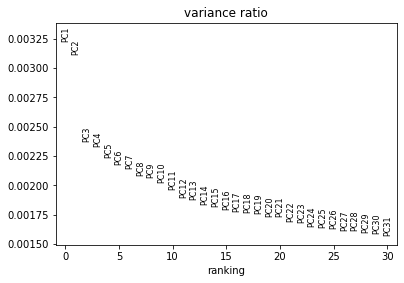

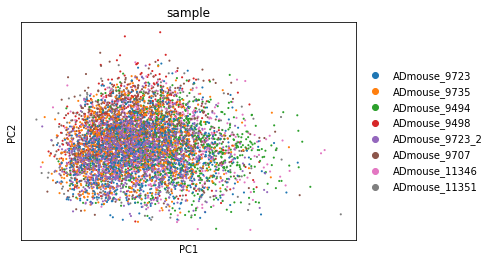

In [158]:
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack', use_highly_variable=True)

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Plot PCA
sc.pl.pca(sdata, color='sample')

In [159]:
%%time
# Computing the neighborhood graph
n_neighbors = emb_dict[sub_id]['n_neighbors']
n_pcs = emb_dict[sub_id]['n_pcs']
min_dist = emb_dict[sub_id]['min_dist']

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata, min_dist=min_dist)
sc.tl.diffmap(sdata, n_comps=n_pcs)

Wall time: 14.1 s


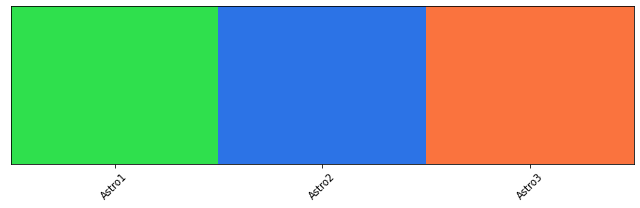

In [160]:
# Check color legend
current_cell_type_order = [i for i in adata.uns['cell_type_order'] if i in sdata.obs['cell_type'].unique()]
sub_cpl = []
for i in current_cell_type_order:
    sub_cpl.append(adata.uns['cell_type_rgb_dict'][i])

sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(current_cell_type_order)), current_cell_type_order, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_top.png')
plt.show()

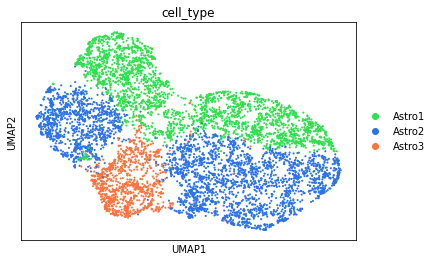

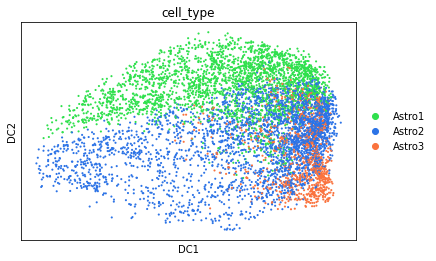

In [161]:
# Plot embeddings
sc.pl.umap(sdata, color='cell_type', palette=sub_cpl)
sc.pl.diffmap(sdata, color='cell_type', palette=sub_cpl)

In [162]:
# Save embeddings
if save_embedding:
    
    np.savetxt(f'{fig_path}/embedding_{sub_id}_umap.csv', sdata.obsm['X_umap'], delimiter=",")
    np.savetxt(f'{fig_path}/embedding_{sub_id}_diffmap.csv', sdata.obsm['X_diffmap'], delimiter=",")

In [163]:
# Constrcut embedding df
embed_df = sdata.obs.loc[:, ['cell_type']]
embed_df['x'] = sdata.obsm['X_diffmap'][:, 1]
embed_df['y'] = sdata.obsm['X_diffmap'][:, 2]
embed_df['index'] = embed_df.index.values
embed_df

cell_type         x         y  index
5        Astro2 -0.025657 -0.019065      5
7        Astro3  0.002494 -0.022298      7
8        Astro2  0.008527 -0.003570      8
18       Astro2  0.005074 -0.013442     18
20       Astro1 -0.009948 -0.000078     20
...         ...       ...       ...    ...
76799    Astro2 -0.031351 -0.008331  76799
76809    Astro2 -0.007336 -0.024575  76809
76819    Astro1 -0.006046  0.014481  76819
76821    Astro2 -0.010439 -0.026530  76821
76823    Astro2 -0.003271 -0.002382  76823

[6789 rows x 4 columns]

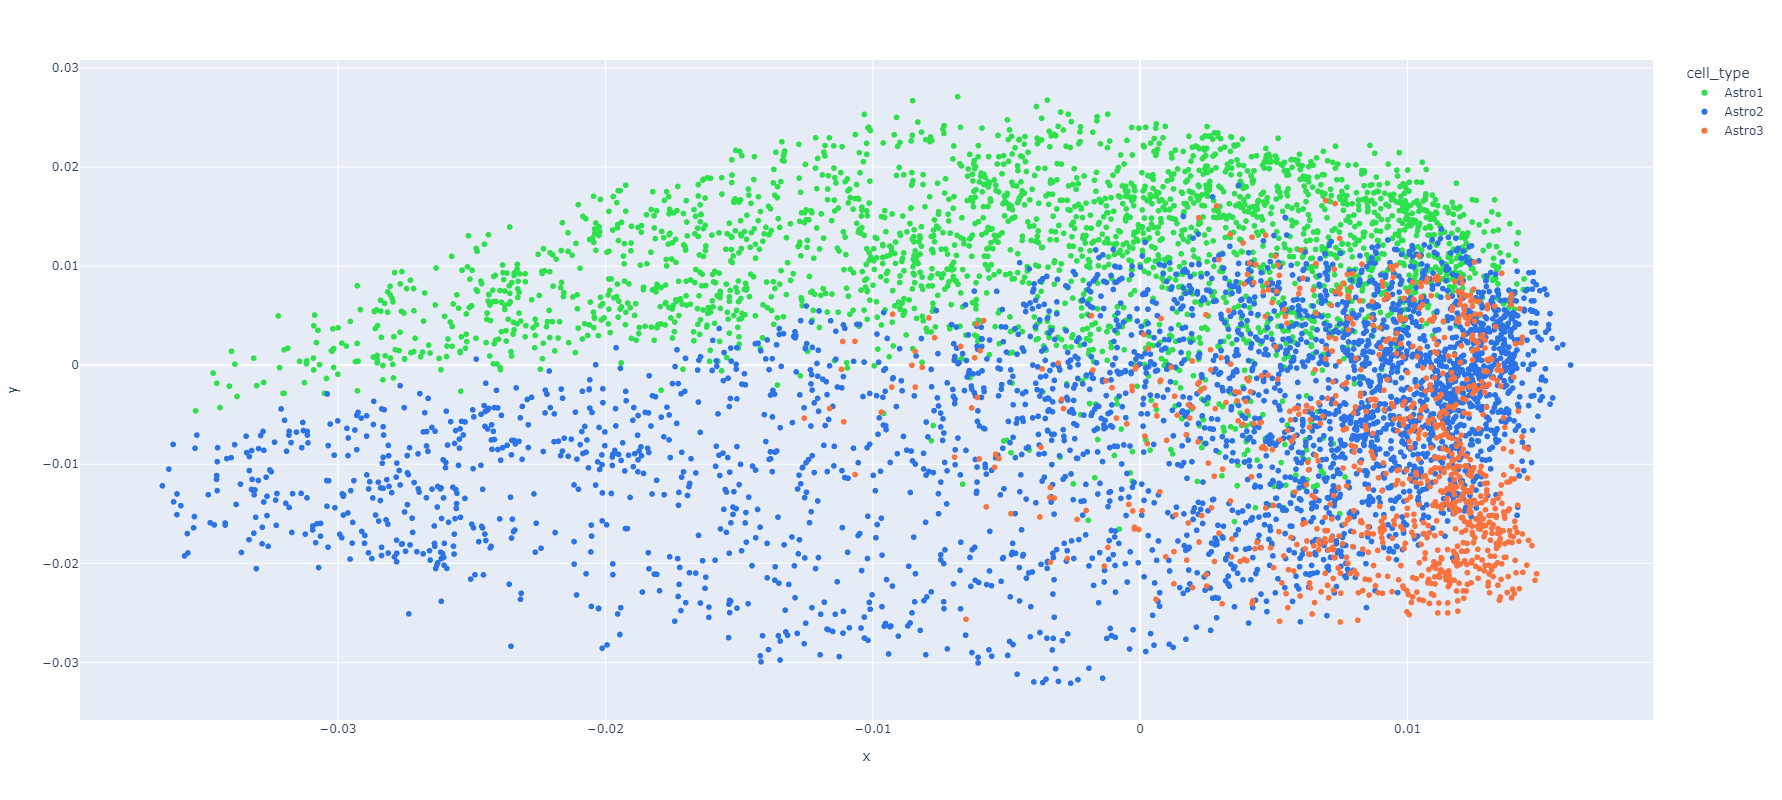

In [164]:

fig = px.scatter(embed_df, x='x', y='y', color='cell_type', hover_data=['index'], 
                 color_discrete_sequence=list(sub_cpl.as_hex()),
                 category_orders={"cell_type": current_cell_type_order}
                )
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [165]:
# DPT pseudotime
current_root = '71212' # 45472 micro top bottom root 68455 micro top bottom root, 71212 for astro
sdata.var['xroot'] = sdata[current_root, :].X.flatten() 
sc.tl.dpt(sdata, n_branchings=1, n_dcs=3)

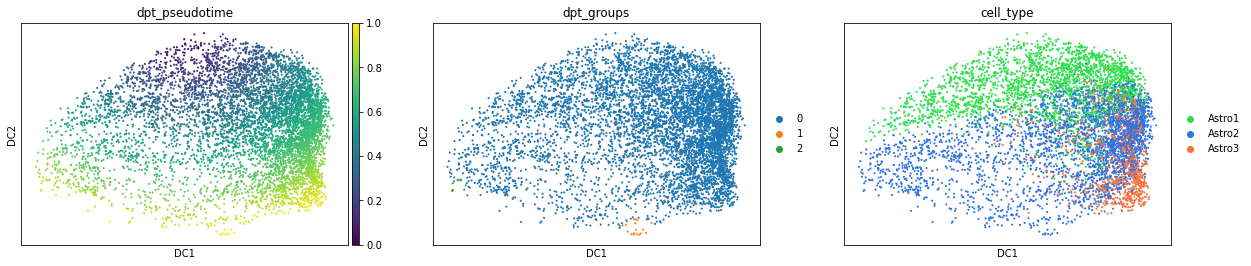

In [166]:
# DPT visualize 
sc.pl.diffmap(sdata, color=['dpt_pseudotime', 'dpt_groups', 'cell_type'])

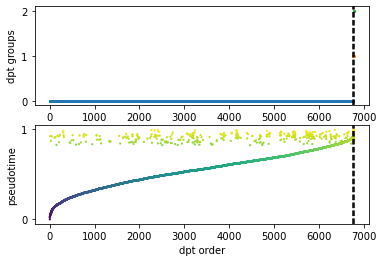

In [167]:
sc.pl.dpt_groups_pseudotime(sdata)

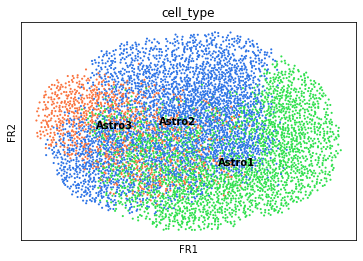

In [168]:
sc.tl.draw_graph(sdata)
sc.pp.neighbors(sdata, n_neighbors=30, use_rep='X_diffmap')
sc.pl.draw_graph(sdata, color='cell_type', legend_loc='on data')

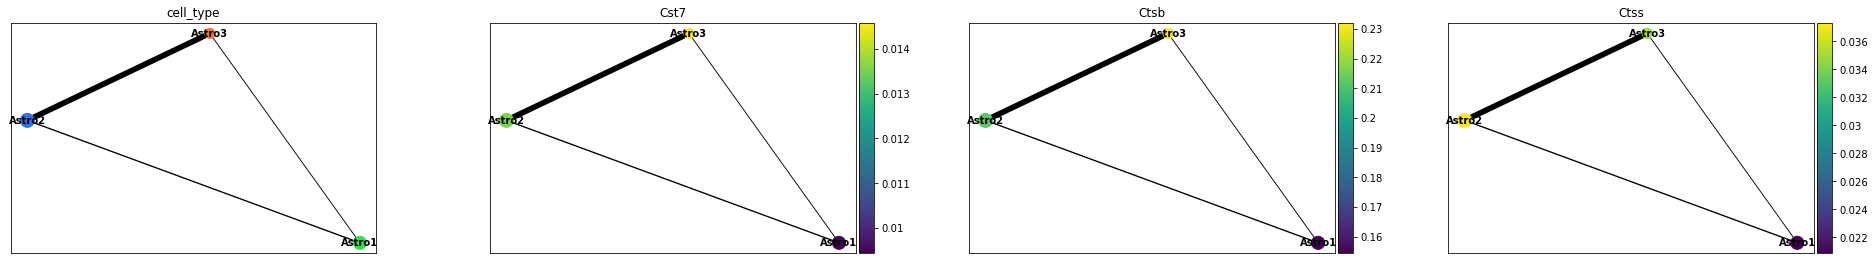

In [169]:
sc.tl.paga(sdata, groups='cell_type')
sc.pl.paga(sdata, color=['cell_type', 'Cst7', 'Ctsb', 'Ctss'])

### multiple types

In [125]:
# Subset (Oligo & OPC)
curr_cells = (adata.obs['top_level'] == 'Oligo') | (adata.obs['top_level'] == 'OPC')
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 12534 × 2766
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'tau', 'group', 'time', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'top_level', 'cell_type', 'seg_label', 'region', 'time-group'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'detected', 'highly_variable', 'n_cells', 'mean', 'std'
    uns: 'ADmouse_11346_morph', 'ADmouse_11351_morph', 'ADmouse_9494_morph', 'ADmouse_9498_morph', 'ADmouse_9707_morph', 'ADmouse_9723_2_morph', 'ADmouse_9723_morph', 'ADmouse_9735_morph', 'cell_type_hex_dict', 'cell_type_order', 'cell_type_rgb_dict', 'top_level_hex_dict', 'top_level_order', 'top_level_rgb_dict', 'iroot'
    layers: 'corrected', 'norm', 'raw', 'scaled'

In [126]:
sub_level_fig_path = os.path.join(fig_path, 'Oligo_OPC')
if not os.path.exists(sub_level_fig_path):
    os.mkdir(sub_level_fig_path)

In [131]:
del sdata.uns['iroot']

#### Embedding

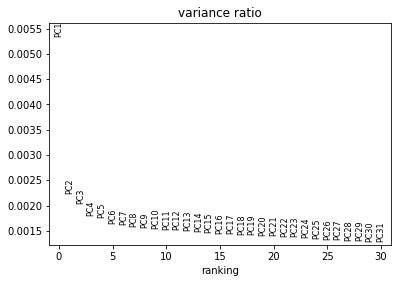

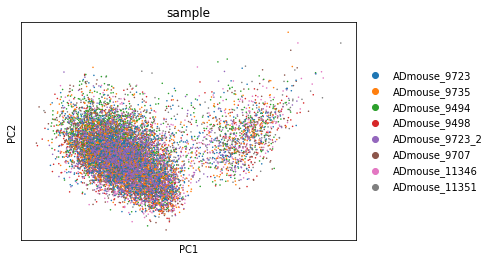

In [132]:
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack', use_highly_variable=True)

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Plot PCA
sc.pl.pca(sdata, color='sample')

In [133]:
%%time
# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 5
min_dist = 0.1

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata, min_dist=min_dist)
sc.tl.diffmap(sdata, n_comps=n_pcs)

Wall time: 23.4 s


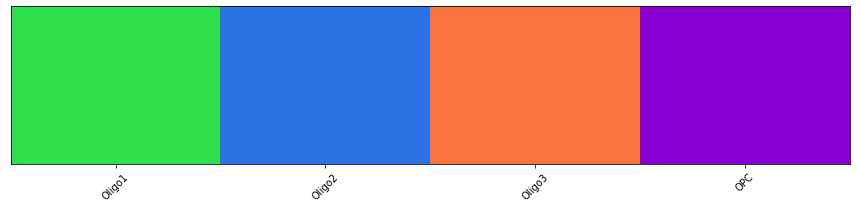

In [134]:
# Check color legend
current_cell_type_order = [i for i in adata.uns['cell_type_order'] if i in sdata.obs['cell_type'].unique()]
sub_cpl = []
for i in current_cell_type_order:
    sub_cpl.append(adata.uns['cell_type_rgb_dict'][i])

sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(current_cell_type_order)), current_cell_type_order, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_top.png')
plt.show()

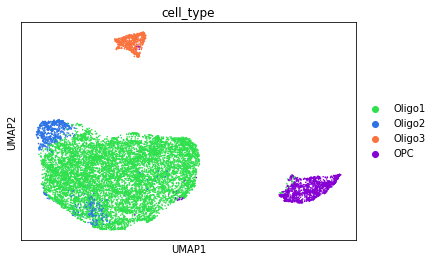

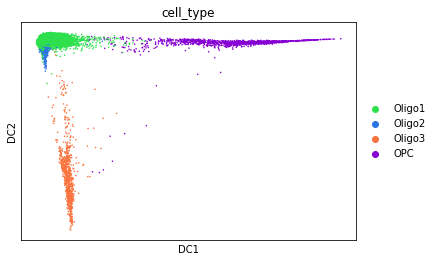

In [135]:
# Plot embeddings
sc.pl.umap(sdata, color='cell_type', palette=sub_cpl)
sc.pl.diffmap(sdata, color='cell_type', palette=sub_cpl)

In [136]:
# save embeddings
if save_embedding:

    np.savetxt(f'{fig_path}/embedding_Oligo_OPC_umap.csv', sdata.obsm['X_umap'], delimiter=",")
    np.savetxt(f'{fig_path}/embedding_Oligo_OPC_diffmap.csv', sdata.obsm['X_diffmap'], delimiter=",")

In [137]:
# Constrcut embedding df
embed_df = sdata.obs.loc[:, ['cell_type']]
embed_df['x'] = sdata.obsm['X_diffmap'][:, 1]
embed_df['y'] = sdata.obsm['X_diffmap'][:, 2]
embed_df['index'] = embed_df.index.values
embed_df

cell_type         x         y  index
27       Oligo1 -0.001449  0.002262     27
29          OPC  0.028476  0.002061     29
37          OPC  0.029309  0.001794     37
44       Oligo1 -0.001047  0.003559     44
47       Oligo1  0.000306  0.001351     47
...         ...       ...       ...    ...
76792       OPC  0.020922  0.001961  76792
76808    Oligo1 -0.002137  0.002375  76808
76813       OPC  0.011908  0.002224  76813
76818    Oligo1 -0.001168  0.003085  76818
76836    Oligo1  0.003390  0.002904  76836

[12534 rows x 4 columns]

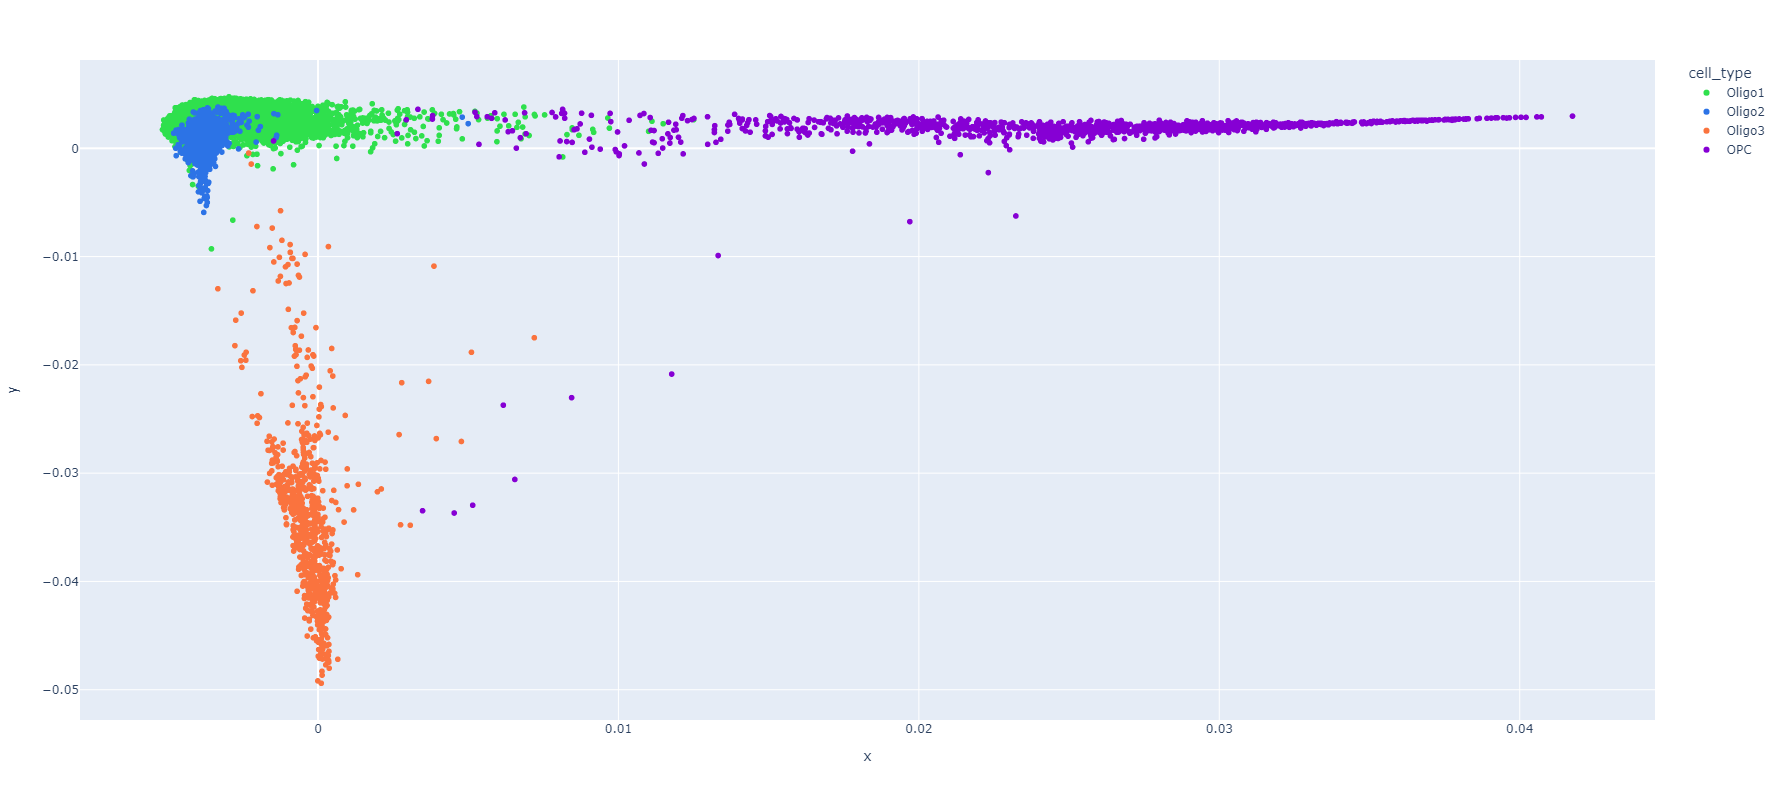

In [138]:

fig = px.scatter(embed_df, x='x', y='y', color='cell_type', hover_data=['index'], 
                 color_discrete_sequence=list(sub_cpl.as_hex()),
                 category_orders={"cell_type": current_cell_type_order}
                )
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [146]:
# DPT pseudotime
current_root = '24082' # 45472 micro top bottom root 68455 micro top bottom root
sdata.var['xroot'] = sdata[current_root, :].X.flatten() 
sc.tl.dpt(sdata, n_branchings=0, n_dcs=5)

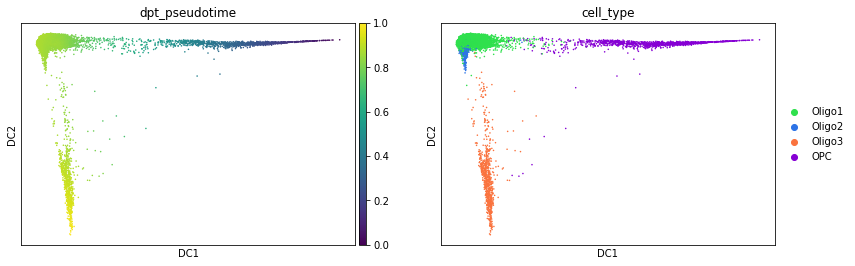

In [147]:
# DPT visualize 
sc.pl.diffmap(sdata, color=['dpt_pseudotime', 'cell_type'])

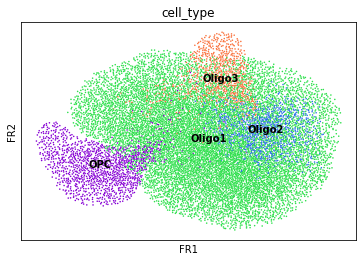

In [149]:
sc.tl.draw_graph(sdata)
sc.pp.neighbors(sdata, n_neighbors=30, use_rep='X_diffmap')
sc.pl.draw_graph(sdata, color='cell_type', legend_loc='on data')

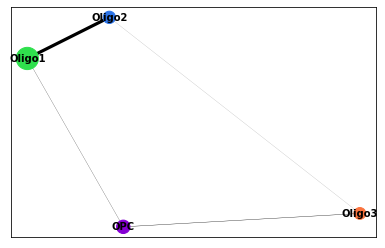

In [151]:
sc.tl.paga(sdata, groups='cell_type')
sc.pl.paga(sdata, color='cell_type')